Epoch 001 | train MSE=4.125855e-02 | val MSE=1.437372e-02
Epoch 005 | train MSE=7.016329e-03 | val MSE=7.671352e-03
Epoch 010 | train MSE=5.423106e-03 | val MSE=5.375813e-03
Epoch 015 | train MSE=4.569764e-03 | val MSE=4.413036e-03
Epoch 020 | train MSE=4.168065e-03 | val MSE=4.084788e-03
Epoch 025 | train MSE=3.719821e-03 | val MSE=3.687793e-03
Epoch 030 | train MSE=3.493898e-03 | val MSE=3.340848e-03
Epoch 035 | train MSE=3.363357e-03 | val MSE=3.248929e-03
Epoch 040 | train MSE=3.086093e-03 | val MSE=3.199411e-03
Epoch 045 | train MSE=2.994887e-03 | val MSE=3.345362e-03
Epoch 050 | train MSE=2.816840e-03 | val MSE=2.999919e-03
Epoch 055 | train MSE=2.738612e-03 | val MSE=2.945605e-03
Epoch 060 | train MSE=2.638855e-03 | val MSE=2.825429e-03


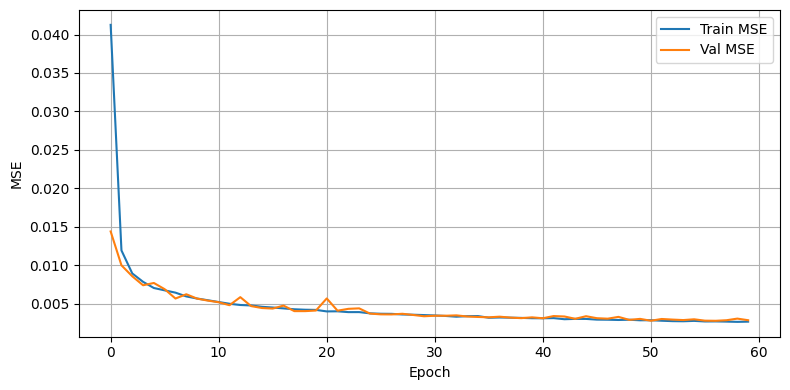

[Test pairs] RMSE=1.4749e-02 | Rel-L2=4.1731e-02


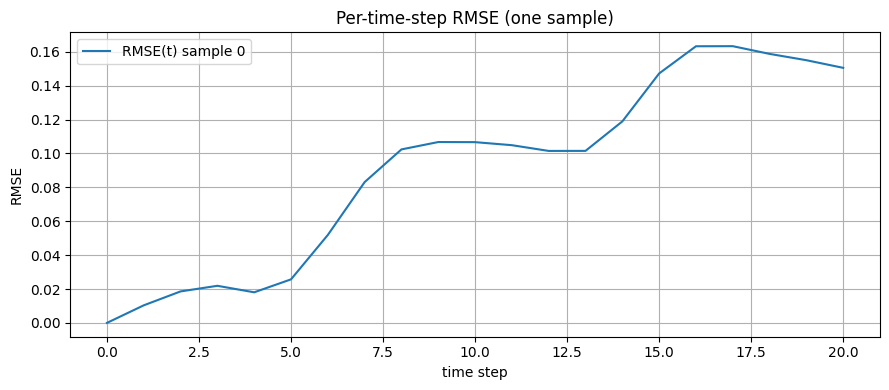

Saved animation → advec_mamba_rollout.gif


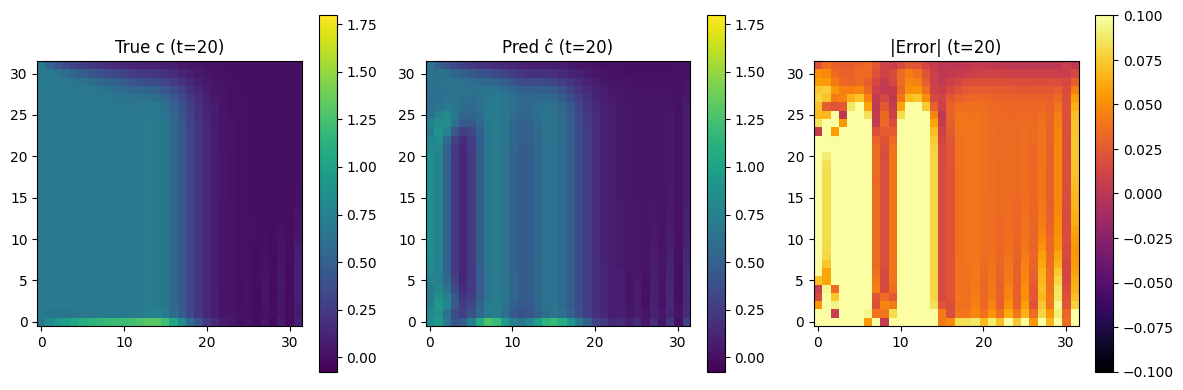

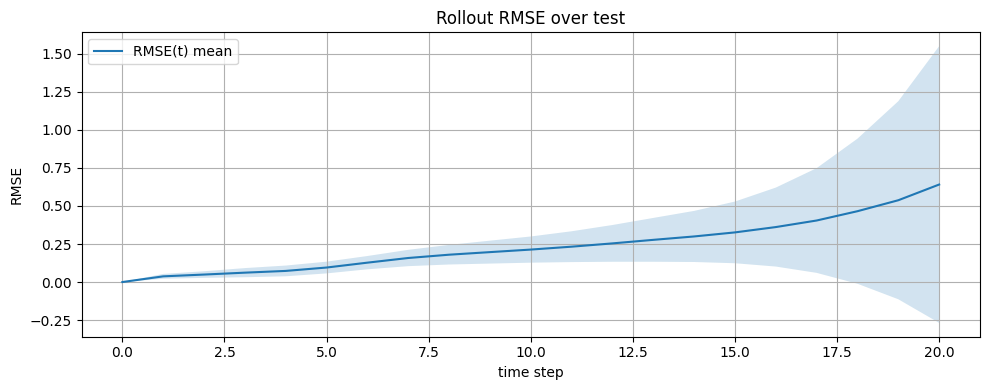

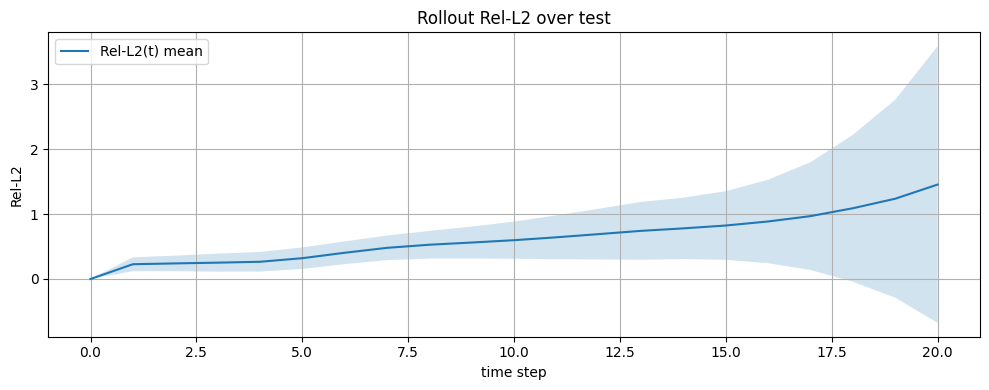

Overall RMSE (mean over B×T): 2.3769e-01
Overall Rel-L2 (mean over B×T): 6.2832e-01


In [ ]:
import os, math
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mamba_ssm import Mamba

# ============================================================
#  DATASETS
# ============================================================

class AdvecPairsNPZ(Dataset):
    """
    Stepper pairs dataset (single-step):
      X: (N, 5, H, W) with channels [c^n, vx^n, vy^n, D, phi]
      Y: (N, H, W)    target = c^{n+1}
    Provides channel-wise normalization stats (from train).
    """
    def __init__(self, npz_path, normalize=True, stats=None):
        data = np.load(npz_path)
        self.X = torch.tensor(data["X"], dtype=torch.float32)  # (N,5,H,W)
        self.Y = torch.tensor(data["Y"], dtype=torch.float32)  # (N,H,W)
        self.normalize = normalize

        if normalize:
            if stats is None:
                X_mean = self.X.mean(dim=(0,2,3), keepdim=True)                 # (1,5,1,1)
                X_std  = self.X.std(dim=(0,2,3), keepdim=True).clamp_min(1e-6)
                Y_mean = self.Y.mean()
                Y_std  = self.Y.std().clamp_min(1e-6)
                self.stats = {
                    "X_mean": X_mean, "X_std": X_std,
                    "Y_mean": Y_mean, "Y_std": Y_std
                }
            else:
                self.stats = stats

            self.X = (self.X - self.stats["X_mean"]) / self.stats["X_std"]
            self.Y = (self.Y - self.stats["Y_mean"]) / self.stats["Y_std"]

    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i): return self.X[i], self.Y[i]


class WindowedAdvecSeq(Dataset):
    """
    Windowed dataset built from full sequences:
      c:   (B, T+1, H, W)
      v:   (B, T+1, H, W, 2)
      D:   (B, H, W)
      phi: (B, H, W)
    Each item is:
      X_window: (L, 5, H, W) with channels [c^τ, vx^τ, vy^τ, D, phi] for τ in [t-L+1..t]
      Y:        (H, W)       target = c^{t+1}
    We use normalization stats learned from the PAIRS dataset to keep consistency.
    """
    def __init__(self, seq_npz_path, L, stats):
        data = np.load(seq_npz_path)
        self.c   = data["c"]    # (B,T+1,H,W)
        self.v   = data["v"]    # (B,T+1,H,W,2)
        self.D   = data["D"]    # (B,H,W)
        self.phi = data["phi"]  # (B,H,W)
        self.B, self.T1, self.H, self.W = self.c.shape
        self.L = L

        # Build indices t where target exists and window fits:
        T = self.T1 - 1
        self.indices = [(b, t) for b in range(self.B) for t in range(L-1, T)]

        # Store stats (torch tensors expected)
        self.stats = stats

    def __len__(self): return len(self.indices)

    def __getitem__(self, idx):
        b, t = self.indices[idx]
        frames = []
        for k in range(self.L):
            tau = t - (self.L - 1) + k
            frames.append(np.stack([
                self.c[b, tau],
                self.v[b, tau, :, :, 0],
                self.v[b, tau, :, :, 1],
                self.D[b],
                self.phi[b]
            ], axis=0))  # (5,H,W)
        X = np.stack(frames, axis=0)       # (L,5,H,W)
        Y = self.c[b, t+1]                 # (H,W)

        # Normalize using PAIRS stats for consistency
        X = (X - self.stats["X_mean"].numpy()) / self.stats["X_std"].numpy()
        Y = (Y - float(self.stats["Y_mean"])) / float(self.stats["Y_std"])

        return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)

# ============================================================
#  MODEL: Spatial CNN encoder + Mamba temporal mixer
# ============================================================

class MambaBlock(nn.Module):
    def __init__(self, d_model, dropout=0.1):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.mamba = Mamba(d_model=d_model)
        self.drop = nn.Dropout(dropout)
    def forward(self, x):                 # (B*H*W, L, d)
        h = self.mamba(self.norm(x))
        return x + self.drop(h)

def sinusoidal_time_emb(L, d, device):
    pe = torch.zeros(L, d, device=device)
    pos = torch.arange(L, device=device).unsqueeze(1)
    div = torch.exp(torch.arange(0, d, 2, device=device) * (-math.log(10000.0)/d))
    pe[:,0::2] = torch.sin(pos*div); pe[:,1::2] = torch.cos(pos*div)
    return pe

class SpatialEncoder(nn.Module):
    def __init__(self, in_ch=5, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, hidden, 3, padding=1), nn.GELU(),
            nn.Conv2d(hidden, hidden, 3, padding=1), nn.GELU()
        )
    def forward(self, x):  # (B*L,5,H,W)
        return self.net(x) # (B*L,d,H,W)

class MambaAdvecStepper(nn.Module):
    """
    Input:  (B, L, 5, H, W)  with channels [c, vx, vy, D, phi]
    Output: (B, H, W)  predicts c^{t+1}
    """
    def __init__(self, hidden=64, n_layers=4, dropout=0.1):
        super().__init__()
        self.enc = SpatialEncoder(in_ch=5, hidden=hidden)
        self.temporal = nn.Sequential(*[MambaBlock(hidden, dropout) for _ in range(n_layers)])
        self.head = nn.Linear(hidden, 1)

    def forward(self, x):                 # x: (B,L,5,H,W)
        B, L, C, H, W = x.shape
        z = x.reshape(B*L, C, H, W)
        z = self.enc(z)                   # (B*L,d,H,W)
        d = z.shape[1]
        z = z.reshape(B, L, d, H, W).permute(0,3,4,1,2).contiguous()  # (B,H,W,L,d)
        z = z.view(B*H*W, L, d)                                     # (B*H*W,L,d)
        z = z + sinusoidal_time_emb(L, d, device=z.device).unsqueeze(0)
        z = self.temporal(z)
        y = self.head(z[:, -1, :]).squeeze(-1)                      # (B*H*W,)
        return y.view(B, H, W)

# ============================================================
#  TRAIN / EVAL (single-step on pairs)
# ============================================================

def train_epoch(model, loader, opt, device):
    model.train()
    total = 0.0
    for X, Y in loader:
        X, Y = X.to(device), Y.to(device)
        opt.zero_grad()
        Yhat = model(X)  # (B,H,W)
        loss = F.mse_loss(Yhat, Y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        total += loss.item()
    return total / len(loader)

@torch.no_grad()
def eval_epoch(model, loader, device):
    model.eval()
    total = 0.0
    for X, Y in loader:
        X, Y = X.to(device), Y.to(device)
        Yhat = model(X)
        total += F.mse_loss(Yhat, Y).item()
    return total / len(loader)

# ============================================================
#  ROLLOUT from full sequences (THW per sample)
# ============================================================

@torch.no_grad()
def rollout_mamba_single(model, stats, c_true, v_seq, D, phi,
                         L=4, warmup=0, device="cpu",
                         clamp_left_boundary=False):
    """
    Autoregressive rollout using a sliding window of length L.
      c_true: (T+1,H,W)
      v_seq:  (T+1,H,W,2)
      D,phi:  (H,W)
    Returns: c_pred (T+1,H,W), rmse_t (T+1,), rel_l2_t (T+1,)
    """
    device = torch.device(device)
    model.eval()

    X_mean = stats["X_mean"].to(device)  # (1,5,1,1)
    X_std  = stats["X_std"].to(device)
    Y_mean = float(stats["Y_mean"])
    Y_std  = float(stats["Y_std"])

    T1, H, W = c_true.shape
    T = T1 - 1
    c_pred = np.zeros_like(c_true)
    c_pred[0] = c_true[0]

    # optional warmup copies
    for t in range(1, min(warmup, T)+1):
        c_pred[t] = c_true[t]

    start_n = max(warmup, L-1)
    for t in range(1, start_n+1):
        if not c_pred[t].any():
            c_pred[t] = c_true[t]

    for n in range(start_n, T):
        frames = []
        for k in range(L):
            tau = n - (L - 1) + k
            frames.append(np.stack([
                c_pred[tau],
                v_seq[tau,:,:,0],
                v_seq[tau,:,:,1],
                D, phi
            ], axis=0))
        X = np.stack(frames, axis=0)                 # (L,5,H,W)
        X_t = torch.from_numpy(X).float().unsqueeze(0).to(device)  # (1,L,5,H,W)
        X_t = (X_t - X_mean) / X_std

        Yhat_norm = model(X_t).squeeze(0).cpu().numpy()
        Yhat = Yhat_norm * Y_std + Y_mean

        if clamp_left_boundary:
            Yhat[0, :] = c_true[n+1, 0, :]

        c_pred[n+1] = Yhat

    rmse_t = np.zeros(T1); rel_l2_t = np.zeros(T1)
    for t in range(T1):
        err = c_pred[t] - c_true[t]
        rmse_t[t] = np.sqrt(np.mean(err**2))
        denom = np.linalg.norm(c_true[t].ravel()) + 1e-12
        rel_l2_t[t] = np.linalg.norm(err.ravel()) / denom

    return c_pred, rmse_t, rel_l2_t

# ============================================================
#  VISUALIZATIONS: per-step RMSE + animation
# ============================================================

def animate_triptych(c_true, c_pred, interval=80, cmap="viridis", save_path="advec_mamba_rollout.gif"):
    T1, H, W = c_true.shape
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    vmin = min(c_true.min(), c_pred.min())
    vmax = max(c_true.max(), c_pred.max())

    im0 = axes[0].imshow(c_true[0], origin="lower", cmap=cmap, vmin=vmin, vmax=vmax)
    axes[0].set_title("True c");   plt.colorbar(im0, ax=axes[0])
    im1 = axes[1].imshow(c_pred[0], origin="lower", cmap=cmap, vmin=vmin, vmax=vmax)
    axes[1].set_title("Pred ĉ");   plt.colorbar(im1, ax=axes[1])
    im2 = axes[2].imshow(np.abs(c_true[0]-c_pred[0]), origin="lower", cmap="inferno")
    axes[2].set_title("|Error|");  plt.colorbar(im2, ax=axes[2])

    def update(frame):
        im0.set_data(c_true[frame])
        im1.set_data(c_pred[frame])
        im2.set_data(np.abs(c_true[frame]-c_pred[frame]))
        axes[0].set_title(f"True c (t={frame})")
        axes[1].set_title(f"Pred ĉ (t={frame})")
        axes[2].set_title(f"|Error| (t={frame})")
        return [im0, im1, im2]

    ani = animation.FuncAnimation(fig, update, frames=T1, interval=interval, blit=False)
    plt.tight_layout()
    if save_path:
        ani.save(save_path, writer="pillow", fps=max(1, int(1000/interval)))
    return ani

# ============================================================
#  MAIN: Train on PAIRS
# ============================================================

def main(
    train_pairs="train_advec_pairs.npz",
    test_pairs="test_advec_pairs.npz",
    test_seq="test_advec_seq.npz",
    L=4, hidden=64, n_layers=4, dropout=0.1,
    epochs=60, batch_size=16, lr=3e-4, weight_decay=1e-4,
    val_split=0.1, early_stop_patience=10,
    device=None, save_path="mamba_advec_stepper.pt",
    clamp_left_boundary=False, warmup=0
):
    device = torch.device(device or ("cuda" if torch.cuda.is_available() else "cpu"))

    # ---- Load pairs for training (compute stats here) ----
    full_pairs = AdvecPairsNPZ(train_pairs, normalize=True)
    pairs_stats = full_pairs.stats  # (computed from train pairs)
    n_total = len(full_pairs)
    n_val = max(1, int(val_split * n_total))
    n_train = n_total - n_val
    train_ds, val_ds = random_split(full_pairs, [n_train, n_val], generator=torch.Generator().manual_seed(0))


    class PairsAsWindows(Dataset):
        def __init__(self, pairs_ds, L, stats):
            self.ds = pairs_ds; self.L = L; self.stats = stats
            assert L == 1, "Using pairs as L=1 windows. Set L=1."
        def __len__(self): return len(self.ds)
        def __getitem__(self, idx):
            X, Y = self.ds[idx]          
            X = X.unsqueeze(0)            
            return X, Y

    if L != 1:
        print("NOTE: Training directly on pairs → set L=1 (window length).")
        L = 1

    train_loader = DataLoader(PairsAsWindows(train_ds, L, pairs_stats), batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader   = DataLoader(PairsAsWindows(val_ds,   L, pairs_stats), batch_size=batch_size, shuffle=False, num_workers=0)

    # ---- Model + Optimizer ----
    model = MambaAdvecStepper(hidden=hidden, n_layers=n_layers, dropout=dropout).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # ---- Train (early stopping) ----
    best_val = float("inf"); patience = early_stop_patience
    tr_curve, va_curve = [], []
    for ep in range(1, epochs+1):
        tr = train_epoch(model, train_loader, opt, device)
        va = eval_epoch(model, val_loader, device)
        tr_curve.append(tr); va_curve.append(va)
        if ep % 5 == 0 or ep == 1:
            print(f"Epoch {ep:03d} | train MSE={tr:.6e} | val MSE={va:.6e}")
        if va < best_val - 1e-6:
            best_val = va; patience = early_stop_patience
            torch.save({"model_state": model.state_dict(),
                        "stats": {k: v.cpu() for k, v in pairs_stats.items()},
                        "config": {"L": L, "hidden": hidden, "n_layers": n_layers, "dropout": dropout}},
                       save_path)
        else:
            patience -= 1
            if patience == 0:
                print(f"Early stopping at epoch {ep}. Best val MSE={best_val:.6e}")
                break

    # ---- Curves ----
    plt.figure(figsize=(8,4))
    plt.plot(tr_curve, label="Train MSE"); plt.plot(va_curve, label="Val MSE")
    plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

    # ---- Optional single-step test on PAIRS ----
    if os.path.exists(test_pairs):
        test_ds = AdvecPairsNPZ(test_pairs, normalize=True, stats=pairs_stats)
        test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)
        model.eval()
        rmse_list, rel_list = [], []
        Y_std = float(pairs_stats["Y_std"]); Y_mean = float(pairs_stats["Y_mean"])
        with torch.no_grad():
            for X, Y in test_loader:
                X, Y = X.to(device), Y.to(device)
                X = X.unsqueeze(1)  # to (B,L=1,5,H,W)
                Yhat = model(X)
                # denorm
                Yhat = Yhat * Y_std + Y_mean
                Y    = Y    * Y_std + Y_mean
                diff = (Yhat - Y).cpu().numpy()
                Y_np = Y.cpu().numpy()
                rmse = np.sqrt(np.mean(diff**2))
                rel  = (np.linalg.norm(diff.reshape(diff.shape[0], -1), axis=1) /
                        (np.linalg.norm(Y_np.reshape(Y_np.shape[0], -1), axis=1) + 1e-12)).mean()
                rmse_list.append(rmse); rel_list.append(rel)
        print(f"[Test pairs] RMSE={np.mean(rmse_list):.4e} | Rel-L2={np.mean(rel_list):.4e}")

    # ---- Rollout on full test sequences (autoregressive) ----
    if os.path.exists(test_seq):
        # Reload best
        ckpt = torch.load(save_path, map_location="cpu")
        model.load_state_dict(ckpt["model_state"], strict=True)
        stats = ckpt["stats"]; cfg = ckpt["config"]

        data = np.load(test_seq)
        c_test, v_test, D_test, phi_test = data["c"], data["v"], data["D"], data["phi"]
        B, T1, H, W = c_test.shape
        all_rmse, all_rel = [], []

        # One detailed sample (per-time-step RMSE + animation)
        idx = 0
        c_pred, rmse_t, rel_t = rollout_mamba_single(
            model, stats, c_test[idx], v_test[idx], D_test[idx], phi_test[idx],
            L=cfg["L"], warmup=warmup, device=str(device), clamp_left_boundary=clamp_left_boundary
        )
        # Per-time-step RMSE for this sample
        t = np.arange(T1)
        plt.figure(figsize=(9,4))
        plt.plot(t, rmse_t, label=f"RMSE(t) sample {idx}")
        plt.xlabel("time step"); plt.ylabel("RMSE"); plt.title("Per-time-step RMSE (one sample)")
        plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

        # Animation
        ani = animate_triptych(c_test[idx], c_pred, interval=80, save_path="advec_mamba_rollout.gif")
        print("Saved animation → advec_mamba_rollout.gif")

        # Dataset-wide curves
        for i in range(B):
            cp, rm, rl = rollout_mamba_single(
                model, stats, c_test[i], v_test[i], D_test[i], phi_test[i],
                L=cfg["L"], warmup=warmup, device=str(device), clamp_left_boundary=clamp_left_boundary
            )
            all_rmse.append(rm); all_rel.append(rl)

        all_rmse = np.stack(all_rmse, axis=0)
        all_rel  = np.stack(all_rel, axis=0)

        plt.figure(figsize=(10,4))
        plt.plot(t, all_rmse.mean(0), label="RMSE(t) mean")
        plt.fill_between(t, all_rmse.mean(0)-all_rmse.std(0), all_rmse.mean(0)+all_rmse.std(0), alpha=0.2)
        plt.xlabel("time step"); plt.ylabel("RMSE"); plt.title("Rollout RMSE over test")
        plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

        plt.figure(figsize=(10,4))
        plt.plot(t, all_rel.mean(0), label="Rel-L2(t) mean")
        plt.fill_between(t, all_rel.mean(0)-all_rel.std(0), all_rel.mean(0)+all_rel.std(0), alpha=0.2)
        plt.xlabel("time step"); plt.ylabel("Rel-L2"); plt.title("Rollout Rel-L2 over test")
        plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

        print(f"Overall RMSE (mean over B×T): {all_rmse.mean():.4e}")
        print(f"Overall Rel-L2 (mean over B×T): {all_rel.mean():.4e}")
    else:
        print("Note: test sequence file not found; skipped rollout.")
        
main(
    train_pairs="train_advec_pairs.npz",
    test_pairs="test_advec_pairs.npz",       
    test_seq="test_advec_seq.npz",           
    L=1, hidden=64, n_layers=4, dropout=0.1,
    epochs=60, batch_size=16, lr=3e-4, weight_decay=1e-4,
    val_split=0.1, early_stop_patience=10,
    device=None, save_path="mamba_advec_stepper.pt",
    clamp_left_boundary=False, warmup=0
)

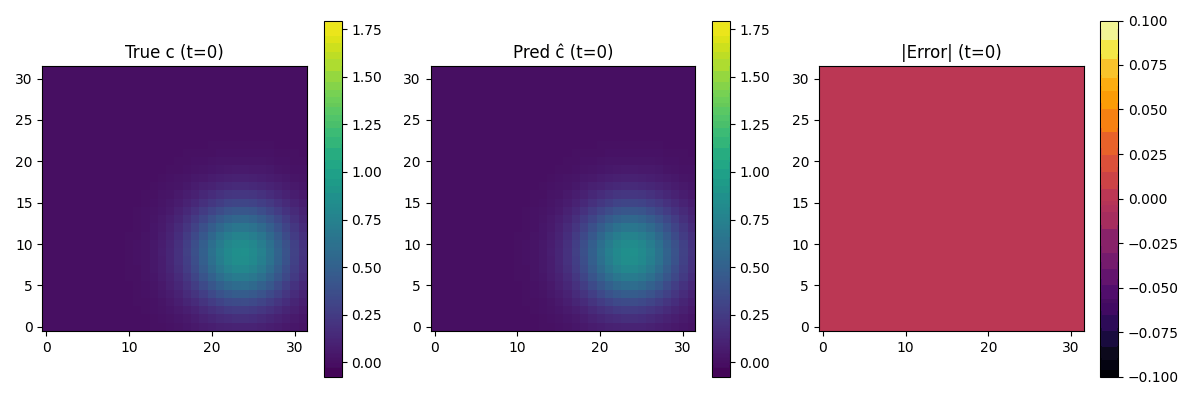

In [2]:
from IPython.display import Image
Image("advec_mamba_rollout.gif")